In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


Importing libraries

In [2]:
# Load datasets
df_2018 = pd.read_csv('Combined_Flights_med_2018.csv')
df_2019 = pd.read_csv('Combined_Flights_med_2019.csv')
df_2020 = pd.read_csv('Combined_Flights_med_2020.csv')
df_2021 = pd.read_csv('Combined_Flights_med_2021.csv')
df_2022 = pd.read_csv('Combined_Flights_med_2022.csv')

# Combine datasets
combined_df = pd.concat([df_2018, df_2019, df_2020, df_2021, df_2022], ignore_index=True)

Loading and combining datasets

In [3]:
# Convert 'FlightDate' to datetime and extract new features 
combined_df['FlightDate'] = pd.to_datetime(combined_df['FlightDate'])
combined_df['Year'] = combined_df['FlightDate'].dt.year
combined_df['Month'] = combined_df['FlightDate'].dt.month
combined_df['DayOfWeek'] = combined_df['FlightDate'].dt.dayofweek

# Now proceed with dropping rows with missing 'Disruption' values
cleaned_df = combined_df.dropna(subset=['Disruption']).copy()

# Assuming 'Year', 'Month', and 'DayOfWeek' have been correctly added to 'cleaned_df'
features = ['CRSDepTime', 'CRSElapsedTime', 'Distance', 'Airline', 'Origin', 'Dest', 'Year', 'Month', 'DayOfWeek']
target = 'Disruption'

# dataframe to use
model_df = cleaned_df[features + [target]]

# Define the split in training and testing
def split_train_test(data, test_ratio, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

# Split the combined dataset into 80% training and 20% testing sets with reproducibility
train_set, test_set = split_train_test(model_df, 0.2, random_state=7)

Processes the flight data by converting the 'FlightDate' column to a datetime format and extracting year, month, and day of the week as new features. Then I remove any records with a missing 'Disruption' data. Finally, I define a function to randomly split the dataset into training and test sets.

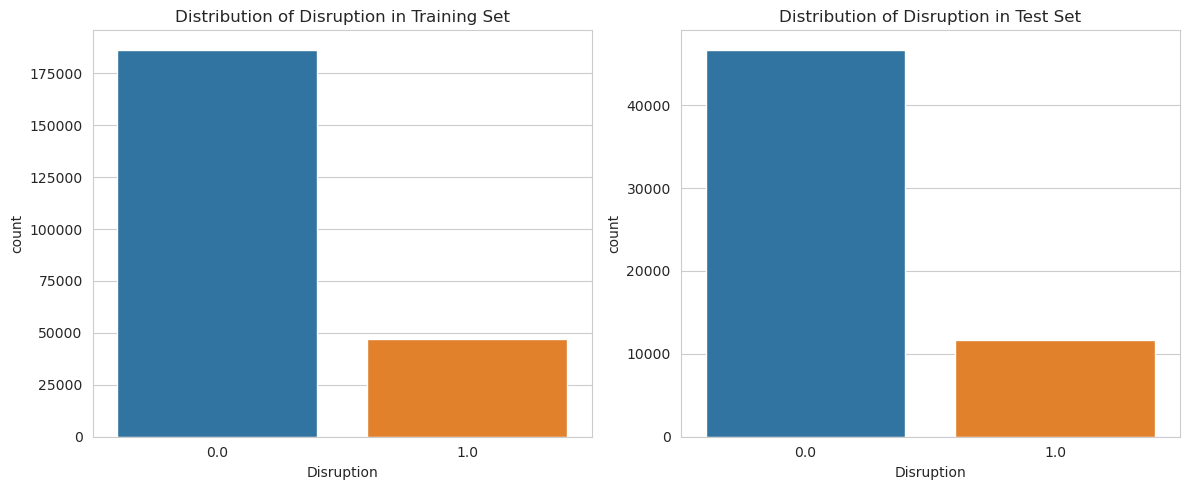

/tmp/ipykernel_479/1735825110.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['IsDisrupted'] = model_df['Disruption'].apply(lambda x: 1 if x > 0 else 0)


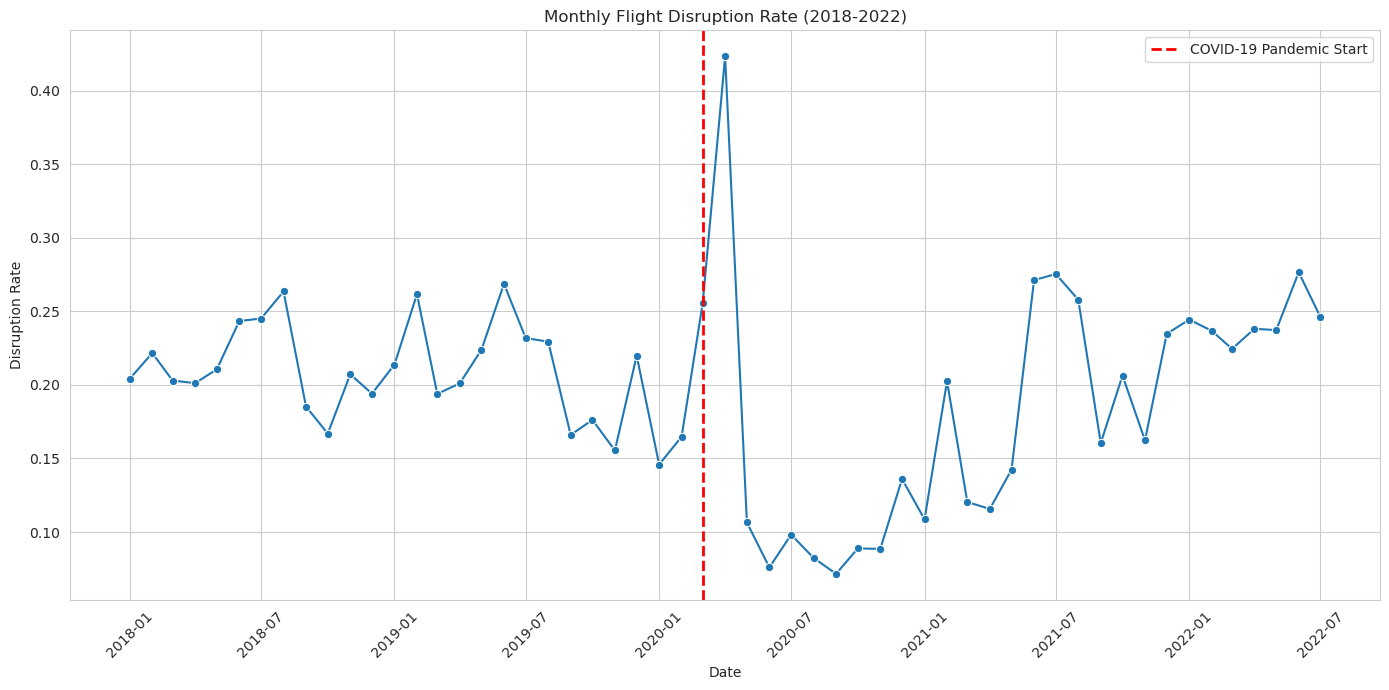

In [4]:
# Setting style 
sns.set_style("whitegrid")

# Creating a figure
plt.figure(figsize=(12, 5))

# Plotting disruption in the training set
plt.subplot(1, 2, 1)  
sns.countplot(x='Disruption', data=train_set)
plt.title('Distribution of Disruption in Training Set')

# Plotting disruption in the test set
plt.subplot(1, 2, 2) 
sns.countplot(x='Disruption', data=test_set)
plt.title('Distribution of Disruption in Test Set')

plt.tight_layout()  
plt.show()

# Create a new column to easily filter disrupted flights
model_df['IsDisrupted'] = model_df['Disruption'].apply(lambda x: 1 if x > 0 else 0)

# Group by Year and Month to calculate disruption rate
monthly_disruption_rate = model_df.groupby(['Year', 'Month']).agg({
    'IsDisrupted': ['sum', 'count']
}).reset_index()

# Calculate the rate of disruptions
monthly_disruption_rate.columns = ['Year', 'Month', 'Disruptions', 'TotalFlights']
monthly_disruption_rate['DisruptionRate'] = monthly_disruption_rate['Disruptions'] / monthly_disruption_rate['TotalFlights']

# Create a datetime index for plotting
monthly_disruption_rate['Date'] = pd.to_datetime(monthly_disruption_rate[['Year', 'Month']].assign(DAY=1))

# Plotting the monthly disruption rate
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='DisruptionRate', data=monthly_disruption_rate, marker='o')
plt.title('Monthly Flight Disruption Rate (2018-2022)')
plt.xlabel('Date')
plt.ylabel('Disruption Rate')
plt.axvline(pd.to_datetime('2020-03-01'), color='red', linestyle='--', lw=2, label='COVID-19 Pandemic Start')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

I visualize the distribution of flight disruptions in both training and test datasets using bar charts (can see the proportions are almost the same so move on) . Also visualize the effect of COVID-19 on disruptions. Can see a huge increase (almost double) following Covid, but a huge drop right after (probably because of no one flying so no disruptions).

In [ ]:
# Define numerical and categorical columns
numerical_cols = ['CRSDepTime', 'CRSElapsedTime', 'Distance', 'DayOfWeek', 'Month']
categorical_cols = ['Airline']

# Define the full pipeline for preprocessing
full_pipeline = ColumnTransformer([
    ("numerical", StandardScaler(), numerical_cols),
    ("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Preparing data for training with pipeline
X = cleaned_df[features]
y = cleaned_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Apply full pipeline to X_train and X_test
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)



Define and train a pipeline for further use in fitting models.

In [6]:
# Initialize the models
decision_tree_clf = DecisionTreeClassifier(random_state=7)
logistic_reg_clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=7)
random_forest_clf = RandomForestClassifier(random_state=7)

# Decision Tree Pipeline
pipeline_dt = Pipeline(steps=[('preprocessor', full_pipeline),
                              ('classifier', decision_tree_clf)])
pipeline_dt.fit(X_train, y_train)

# Logistic Regression Pipeline
pipeline_lr = Pipeline(steps=[('preprocessor', full_pipeline),
                              ('classifier', logistic_reg_clf)])
pipeline_lr.fit(X_train, y_train)

# Random Forest Pipeline
pipeline_rf = Pipeline(steps=[('preprocessor', full_pipeline),
                              ('classifier', random_forest_clf)])
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['CRSDepTime',
                                                   'CRSElapsedTime', 'Distance',
                                                   'DayOfWeek', 'Month']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Airline'])])),
                ('classifier', RandomForestClassifier(random_state=7))])

I create three machine learning models: Decision Tree, Logistic Regression, and Random Forest. I then fit a pipeline to each set of training data.

In [ ]:
# Make predictions on the test set using the pipelines
y_pred_tree = pipeline_dt.predict(X_test)
y_pred_log_reg = pipeline_lr.predict(X_test)
y_pred_rf = pipeline_rf.predict(X_test)

# Calculate probabilities for ROC AUC for all models using the pipelines
y_probs_tree = pipeline_dt.predict_proba(X_test)[:, 1]  # Decision Tree
y_probs_log_reg = pipeline_lr.predict_proba(X_test)[:, 1]  # Logistic Regression
y_probs_rf = pipeline_rf.predict_proba(X_test)[:, 1]  # Random Forest

# Calculate ROC AUC scores
roc_auc_tree = roc_auc_score(y_test, y_probs_tree)
roc_auc_log_reg = roc_auc_score(y_test, y_probs_log_reg)
roc_auc_rf = roc_auc_score(y_test, y_probs_rf)

Make predictions, calculate scores & probabilities

In [ ]:
# Print out the ROC AUC scores
print(f"ROC AUC Score for Decision Tree: {roc_auc_tree:.2f}")
print(f"ROC AUC Score for Logistic Regression: {roc_auc_log_reg:.2f}")
print(f"ROC AUC Score for Random Forest: {roc_auc_rf:.2f}")

# Evaluate the models
print(f"Accuracy of the Decision Tree model: {accuracy_score(y_test, y_pred_tree):.2f}")
print(f"Accuracy of the Logistic Regression model: {accuracy_score(y_test, y_pred_log_reg):.2f}")
print(f"Accuracy of the Random Forest model: {accuracy_score(y_test, y_pred_rf):.2f}")
# Evaluate the models
print(f"Recall of the Decision Tree model: {recall_score(y_test, y_pred_tree):.2f}")
print(f"Recall of the Logistic Regression model: {recall_score(y_test, y_pred_log_reg):.2f}")
print(f"Recall of the Random Forest model: {recall_score(y_test, y_pred_rf):.2f}")
# Display classification reports
print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_pred_tree, zero_division=0))
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_log_reg, zero_division=0))
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

Print out all of the results

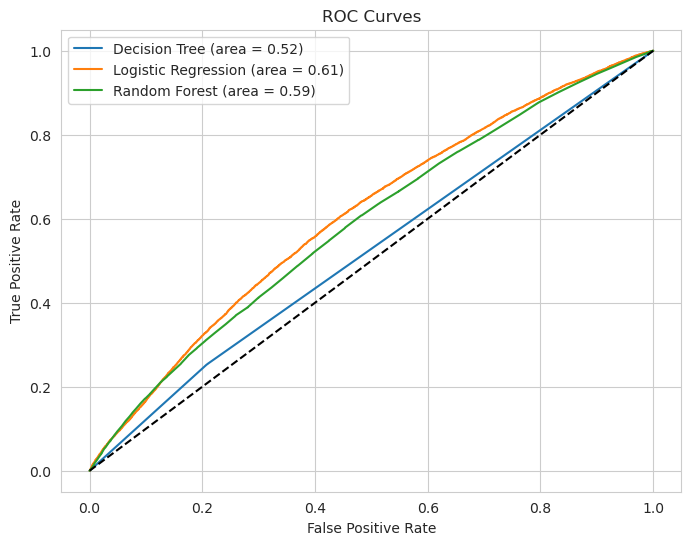

In [11]:
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_probs_tree)
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_probs_log_reg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (area = {roc_auc_tree:.2f})')
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (area = {roc_auc_log_reg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='best')
plt.show()

Graph the ROC curves for each model vs random. Proceed with the random forest because it has better recall for the 0 and worse recall for the 1, however it is more precise. It also shows more promise for fine tuning. 

In [ ]:
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__max_features': ['auto'],
}

# Create the grid search object 
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='recall_macro', n_jobs=-1)

# Fit the grid 
grid_search_rf.fit(X_train, y_train)

print("Best parameters:", grid_search_rf.best_params_)
print("Best recall score:", grid_search_rf.best_score_)


Grid search to fine tune the model and focus on certain parameters (this took almost a day, need to reduce search parameter of use a better laptop)

In [12]:
# Final model evaluation
best_pipeline = grid_search.best_estimator_
y_pred_final = best_pipeline.predict(X_test)
print("Final Model Classification Report:")
print(classification_report(y_test, y_pred_final))

NameError: name 'pipeline' is not defined

Use the fine tuned model fit to fit the data.